## Experimentation Notebook

#### Data exploration

In [175]:
# Load data

import numpy as np
import pandas as pd

df = pd.read_csv("../data/people_data.csv")

df.head()

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...


In [176]:
# Display values by age

pd.set_option('display.max_rows', None)
df['age'].value_counts(sort=True, ascending=False)

age
26     2197
1      1123
28      918
35      880
24      859
25      734
30      724
32      664
27      615
29      570
40      526
36      483
2       482
45      440
23      426
34      409
22      395
50      381
54      353
31      350
21      346
38      325
37      293
60      293
3       289
20      284
4       273
58      271
55      268
42      266
39      265
8       263
18      262
65      259
16      247
53      241
56      236
52      232
5       196
15      177
47      170
9       166
61      159
17      158
14      157
43      157
10      156
85      155
46      153
48      153
75      148
49      148
70      147
33      143
7       139
51      138
80      133
41      132
6       131
12      130
62      125
63      103
68      100
44      100
72       98
19       98
57       97
67       94
59       82
90       82
13       81
66       77
78       69
11       65
73       63
76       58
69       56
64       50
82       40
86       35
88       34
71       33
89       33


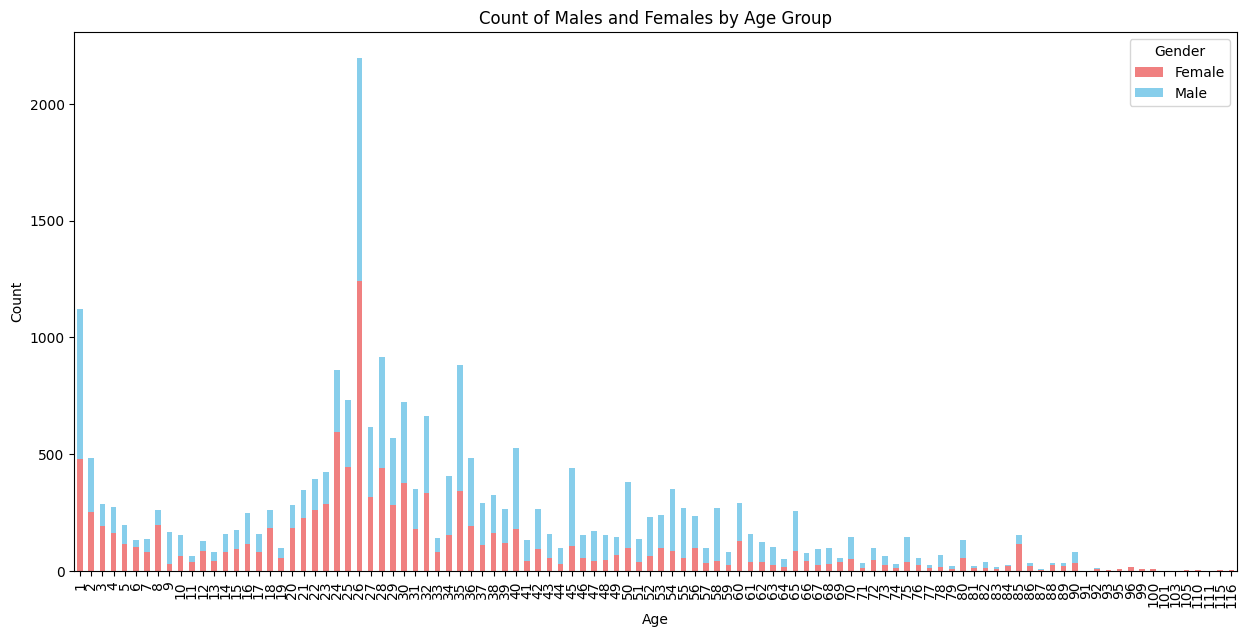

In [177]:
# Show male and female count by age

import matplotlib.pyplot as plt

df['gender'] = df['gender'].replace({0: 'Male', 1: 'Female'})
df['ethnicity'] = df['ethnicity'].replace({0: 'White', 1: 'Black', 2: 'Asiatic', 3: 'Indian', 4: 'Other'})
count_plot = df.groupby(['age', 'gender']).size().unstack(fill_value=0)
count_plot.plot(kind='bar', stacked=True, color=['lightcoral', 'skyblue'], figsize=(15, 7))

plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Count of Males and Females by Age Group')
plt.legend(title='Gender')

plt.show()



In [178]:
# Import libraries

import setuptools.dist
import plotly.graph_objects as go
import plotly.express as px
from keras import layers as L
from sklearn.model_selection import train_test_split

In [179]:
# Convert pixels into array (numpy)

df['pixels'] = df['pixels'].apply(lambda x: np.array(x.split(), dtype="float32") if isinstance(x, str) else x)
df.head()


,age,ethnicity,gender,img_name,pixels
0,1,Asiatic,Male,20161219203650636.jpg.chip.jpg,"[129.0, 128.0, 128.0, 126.0, 127.0, 130.0, 133..."
1,1,Asiatic,Male,20161219222752047.jpg.chip.jpg,"[164.0, 74.0, 111.0, 168.0, 169.0, 171.0, 175...."
2,1,Asiatic,Male,20161219222832191.jpg.chip.jpg,"[67.0, 70.0, 71.0, 70.0, 69.0, 67.0, 70.0, 79...."
3,1,Asiatic,Male,20161220144911423.jpg.chip.jpg,"[193.0, 197.0, 198.0, 200.0, 199.0, 200.0, 202..."
4,1,Asiatic,Male,20161220144914327.jpg.chip.jpg,"[202.0, 205.0, 209.0, 210.0, 209.0, 209.0, 210..."


In [180]:
x = np.array(df['pixels'].tolist())
x = x.reshape(x.shape[0], 48, 48, 1)

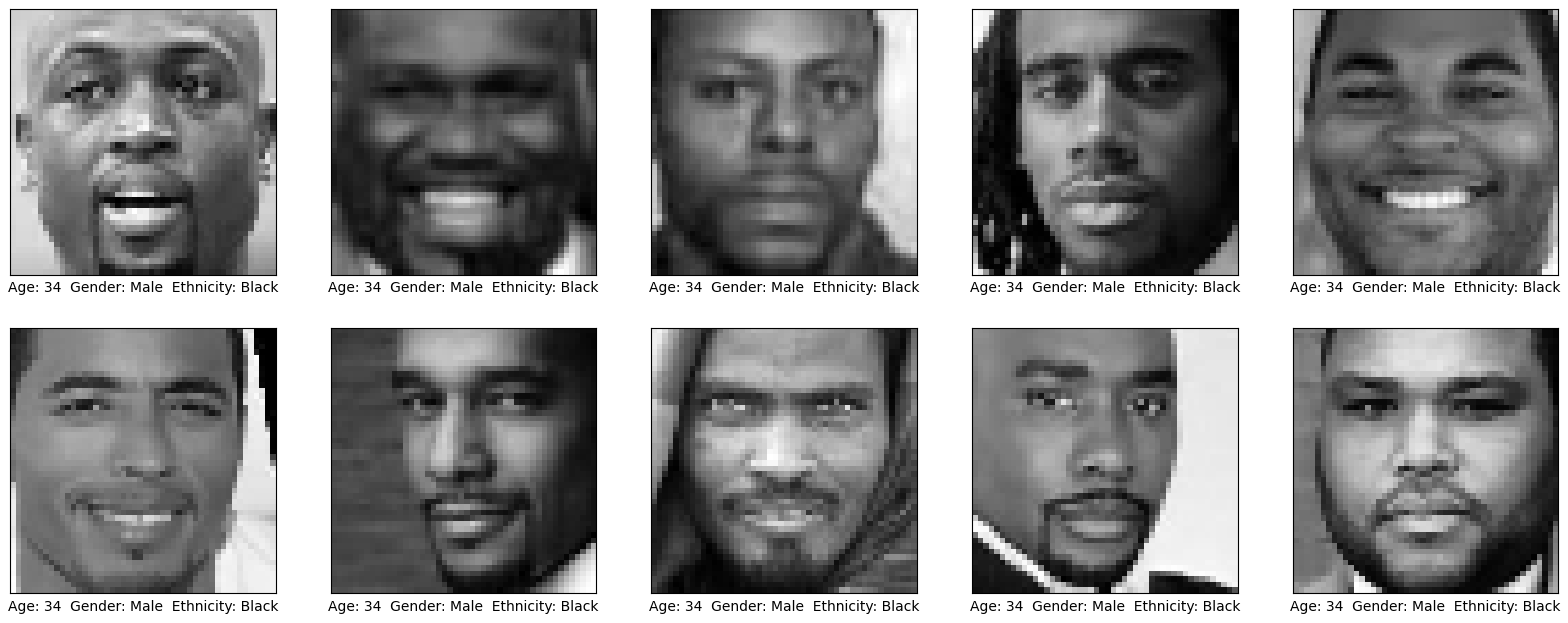

In [187]:
# Display pictures from dataset

plt.figure(figsize=(20, 20))
for i in range(12700,12710):
    plt.subplot(5, 5, (i % 25) + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    
    plt.imshow(df['pixels'].iloc[i].reshape(48, 48), cmap='gray')
    
    plt.xlabel(
        "Age: " + str(df['age'].iloc[i]) +
        "  Gender: " + df['gender'].iloc[i] +
        "  Ethnicity: " + df['ethnicity'].iloc[i]
    )

# Show the plot
plt.show()

#### Gender Prediction Model

In [198]:
# Split gender data frame data into train and test data

# Reverse Male and Female back to 0 and 1 respectively
df['gender'] = df['gender'].replace({'Male': 0, 'Female': 1}).infer_objects(copy=False)
df['gender'] = df['gender'].astype('int8')

y_gender = df['gender']
x_train_gender, x_test_gender, y_train_gender, y_test_gender = train_test_split(x, y_gender, test_size=0.2, random_state=20)

In [199]:
import tensorflow as tf

model_gender = tf.keras.Sequential([
    L.Input(shape=(48, 48, 1)),
    L.Conv2D(32, (3, 3), activation='relu'), 
    L.BatchNormalization(),
    L.MaxPooling2D((2, 2)),
    L.Conv2D(64, (3, 3), activation='relu'),
    L.MaxPooling2D((2, 2)),
    L.Flatten(),
    L.Dense(64, activation='relu'),
    L.Dropout(rate=0.5),
    L.Dense(1, activation='sigmoid')
])

model_gender.compile(
    optimizer='sgd', 
    loss=tf.keras.losses.BinaryCrossentropy(), 
    metrics=['accuracy']
    )

class myCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
        super(myCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs={}):
        if logs is None:
            logs = {}
        current_val_loss = logs.get('val_loss')
        if current_val_loss is not None and current_val_loss < self.threshold:
            print(f"\nReached val_loss of {current_val_loss} which is below {self.threshold}.")
            print("Consider reviewing the model or callback settings.")
        
callback = myCallback(threshold=0.2500)

model_gender.summary()

Model: "sequential_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_84 (Conv2D)              │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (None, 46, 46, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_83 (MaxPooling2D) │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_85 (Conv2D)              │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_84 (MaxPooling2D) │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_35 (Flatten)            │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_70 (Dense)                │ (None, 64)             │       409,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_71 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 428,673 (1.64 MB)

 Trainable params: 428,609 (1.64 MB)

 Non-trainable params: 64 (256.00 B)

In [192]:
x_train_gender = np.array(x_train_gender)
y_train_gender = np.array(y_train_gender)

callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=4,
    min_delta=0.0005,
    restore_best_weights=True
)

history_gender = model_gender.fit(
    x_train_gender, y_train_gender, 
    epochs=20, 
    validation_split=0.12, 
    batch_size=64, 
    callbacks=[callback]
)

Epoch 1/20
261/261 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.6859 - loss: 0.6191 - val_accuracy: 0.8141 - val_loss: 0.4083
Epoch 2/20
261/261 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.8060 - loss: 0.4267 - val_accuracy: 0.8352 - val_loss: 0.3613
Epoch 3/20
261/261 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.8398 - loss: 0.3580 - val_accuracy: 0.8506 - val_loss: 0.3273
Epoch 4/20
261/261 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.8452 - loss: 0.3351 - val_accuracy: 0.8550 - val_loss: 0.3069
Epoch 5/20
261/261 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.8641 - loss: 0.3082 - val_accuracy: 0.8594 - val_loss: 0.3072
Epoch 6/20
261/261 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.8686 - loss: 0.3038 - val_accuracy: 0.8546 - val_loss: 0.3019
Epoch 7/20
261/261 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.8754 - loss: 0.2827 - val_accuracy: 0.8642 - val_loss: 0.2993
Epoch 8/20
261/261 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.8787 - loss: 0.2726 - 

In [194]:
# Loss chart

figure_gender = px.line(
    history_gender.history, y=['loss', 'val_loss'],
    labels={'index': 'epoch', 'value': 'loss'}, 
    title='Training History')

figure_gender.show()

In [196]:
if isinstance(x_test_gender, tuple):
    x_test_gender, y_test_gender = x_test_gender

x_test_gender = np.array(x_test_gender)
y_test_gender = np.array(y_test_gender)

if len(x_test_gender.shape) == 3:  # if shape is (num_samples, 48, 48)
    x_test_gender = x_test_gender.reshape((-1, 48, 48, 1))

y_test_gender = np.array(y_test_gender)

loss, acc = model_gender.evaluate(x_test_gender, y_test_gender, verbose=0)
print('Test loss: {:.4f}'.format(loss))
print('Test Accuracy: {:.2f}%'.format(acc * 100))


Test loss: 0.2700
Test Accuracy: 88.10%


#### Age Prediction Model

In [200]:
y_age = df['age']

x_train_age, x_test_age, y_train_age, y_test_age  = train_test_split(x, y_age, test_size=0.2, random_state=25)

In [201]:
from keras import regularizers

model_age = tf.keras.Sequential([
    L.InputLayer(shape=(48, 48, 1)),
    L.Conv2D(32, (3, 3), activation='relu'),
    L.BatchNormalization(),
    L.MaxPooling2D((2, 2)),
    
    L.Conv2D(64, (3, 3), activation='relu'),
    L.MaxPooling2D((2, 2)),
    
    L.Conv2D(128, (3, 3), activation='relu'),
    L.MaxPooling2D((2, 2)),
    
    L.Flatten(),
    L.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    L.Dropout(rate=0.3),
    
    L.Dense(1, activation='linear')
])

sgd = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
adam = tf.keras.optimizers.Adam(learning_rate=0.0001)

model_age.compile(
    optimizer=adam,
    loss='mae',
    metrics=['mae']
)

class myCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
        super(myCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs={}):
        if logs is None:
            logs = {}
        current_val_loss = logs.get('val_loss')
        if current_val_loss is not None and current_val_loss < self.threshold:
            print(f"\nReached val_loss of {current_val_loss} which is below {self.threshold}.")
            print("Consider reviewing the model or callback settings.")
        
callback = myCallback(threshold=110)

model_age.summary()

Model: "sequential_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_86 (Conv2D)              │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_39          │ (None, 46, 46, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_85 (MaxPooling2D) │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_87 (Conv2D)              │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_86 (MaxPooling2D) │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_88 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_87 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_36 (Flatten)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_72 (Dense)                │ (None, 64)             │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_73 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 224,001 (875.00 KB)

 Trainable params: 223,937 (874.75 KB)

 Non-trainable params: 64 (256.00 B)

In [203]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=7,
    min_delta=0.0005,
    restore_best_weights=True
)

x_train_age = np.array(x_train_age)
y_train_age = np.array(y_train_age)

history_age = model_age.fit(
    x_train_age, y_train_age, 
    epochs=50, 
    validation_split=0.13, 
    batch_size=64, 
    callbacks=[callback]
)

Epoch 1/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 14s 53ms/step - loss: 13.1713 - mae: 13.0509 - val_loss: 11.8998 - val_mae: 11.7829
Epoch 2/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 13s 52ms/step - loss: 11.1398 - mae: 11.0238 - val_loss: 9.5071 - val_mae: 9.3938
Epoch 3/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 13s 50ms/step - loss: 10.1731 - mae: 10.0605 - val_loss: 9.9831 - val_mae: 9.8728
Epoch 4/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 13s 51ms/step - loss: 9.8240 - mae: 9.7145 - val_loss: 8.7884 - val_mae: 8.6807
Epoch 5/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 14s 55ms/step - loss: 9.4753 - mae: 9.3683 - val_loss: 9.0937 - val_mae: 8.9884
Epoch 6/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 14s 54ms/step - loss: 9.2048 - mae: 9.0999 - val_loss: 8.2295 - val_mae: 8.1263
Epoch 7/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 14s 55ms/step - loss: 8.8830 - mae: 8.7803 - val_loss: 8.0631 - val_mae: 7.9620
Epoch 8/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 15s 57ms/step - loss: 8.6919 - mae: 8.5912 - val_loss: 8.9372 - val_mae: 8.8378
Epoch 9/50
258/258 ━━━━━━━━━━━━━

In [204]:
# Chart

figure_age = px.line(
    history_age.history, y=['loss', 'val_loss'],
    labels={'index': 'epoch', 'value': 'loss'}, 
    title='Training History')

figure_age.show()

In [205]:
if isinstance(x_test_age, tuple):
    x_test_age, y_test_age = x_test_age

x_test_age = np.array(x_test_age)
y_test_age = np.array(y_test_age)

mse, mae = model_age.evaluate(x_test_age, y_test_age, verbose=0)

print('Test Mean squared error: {:.2f}'.format(mse))
print('Test Mean absolute error: {:.2f}'.format(mae))

Test Mean squared error: 6.87
Test Mean absolute error: 6.78


##### Ethnicity Predcition Model

In [210]:
# Reverse ethnicities back to 0-4 range
df['ethnicity'] = df['ethnicity'].replace({'White': 0, 'Black': 1, 'Asiatic': 2, 'Indian': 3, 'Other': 4})
df['ethnicity'] = df['ethnicity'].astype('int8').infer_objects(copy=False)

y_ethnicity = df['ethnicity']

x_train_ethnicity, x_test_ethnicity, y_train_ethnicity, y_test_ethnicity = train_test_split(x, y_ethnicity, test_size=0.2, random_state=40)

In [207]:
model_ethnicity = tf.keras.Sequential([
    L.Input(shape=(48, 48, 1)),
    L.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    L.BatchNormalization(),
    L.MaxPooling2D((2, 2)),
    L.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    L.MaxPooling2D((2, 2)),
    L.Flatten(),
    L.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    L.Dropout(rate=0.5),
    L.Dense(5, activation='softmax')
])

model_ethnicity.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

class myCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
        super(myCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs={}):
        if logs is None:
            logs = {}
        current_val_loss = logs.get('val_loss')
        if current_val_loss is not None and current_val_loss < self.threshold:
            print(f"\nReached val_loss of {current_val_loss} which is below {self.threshold}.")
            print("Consider reviewing the model or callback settings.")

callback = myCallback(threshold=0.2500)

model_ethnicity.summary()

Model: "sequential_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_89 (Conv2D)              │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_40          │ (None, 46, 46, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_88 (MaxPooling2D) │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_90 (Conv2D)              │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_89 (MaxPooling2D) │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_37 (Flatten)            │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_74 (Dense)                │ (None, 64)             │       409,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_75 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 428,933 (1.64 MB)

 Trainable params: 428,869 (1.64 MB)

 Non-trainable params: 64 (256.00 B)

In [208]:
from tensorflow import keras
from keras._tf_keras.keras.preprocessing.image import ImageDataGenerator

x_train_ethnicity = np.array(x_train_ethnicity)
y_train_ethnicity = np.array(y_train_ethnicity)

callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=8,
    min_delta=0.0005,
    restore_best_weights=True
)

datagen_ethnicity = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen_ethnicity.fit(x_train_ethnicity)

history_ethnicity = model_ethnicity.fit(
    x_train_ethnicity, y_train_ethnicity, 
    epochs=40, 
    validation_split=0.15,
    batch_size=128, 
    callbacks=[callback]
)

Epoch 1/40


UnimplementedError: Graph execution error:

Detected at node compile_loss/sparse_categorical_crossentropy/Cast defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "c:\Users\gatz0\Desktop\Projects\person-attribute-classification\venv\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>

  File "c:\Users\gatz0\Desktop\Projects\person-attribute-classification\venv\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance

  File "c:\Users\gatz0\Desktop\Projects\person-attribute-classification\venv\Lib\site-packages\ipykernel\kernelapp.py", line 739, in start

  File "c:\Users\gatz0\Desktop\Projects\person-attribute-classification\venv\Lib\site-packages\tornado\platform\asyncio.py", line 205, in start

  File "C:\Users\gatz0\AppData\Local\Programs\Python\Python312\Lib\asyncio\base_events.py", line 618, in run_forever

  File "C:\Users\gatz0\AppData\Local\Programs\Python\Python312\Lib\asyncio\base_events.py", line 1951, in _run_once

  File "C:\Users\gatz0\AppData\Local\Programs\Python\Python312\Lib\asyncio\events.py", line 84, in _run

  File "c:\Users\gatz0\Desktop\Projects\person-attribute-classification\venv\Lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue

  File "c:\Users\gatz0\Desktop\Projects\person-attribute-classification\venv\Lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one

  File "c:\Users\gatz0\Desktop\Projects\person-attribute-classification\venv\Lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell

  File "c:\Users\gatz0\Desktop\Projects\person-attribute-classification\venv\Lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request

  File "c:\Users\gatz0\Desktop\Projects\person-attribute-classification\venv\Lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request

  File "c:\Users\gatz0\Desktop\Projects\person-attribute-classification\venv\Lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute

  File "c:\Users\gatz0\Desktop\Projects\person-attribute-classification\venv\Lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell

  File "c:\Users\gatz0\Desktop\Projects\person-attribute-classification\venv\Lib\site-packages\IPython\core\interactiveshell.py", line 3075, in run_cell

  File "c:\Users\gatz0\Desktop\Projects\person-attribute-classification\venv\Lib\site-packages\IPython\core\interactiveshell.py", line 3130, in _run_cell

  File "c:\Users\gatz0\Desktop\Projects\person-attribute-classification\venv\Lib\site-packages\IPython\core\async_helpers.py", line 128, in _pseudo_sync_runner

  File "c:\Users\gatz0\Desktop\Projects\person-attribute-classification\venv\Lib\site-packages\IPython\core\interactiveshell.py", line 3334, in run_cell_async

  File "c:\Users\gatz0\Desktop\Projects\person-attribute-classification\venv\Lib\site-packages\IPython\core\interactiveshell.py", line 3517, in run_ast_nodes

  File "c:\Users\gatz0\Desktop\Projects\person-attribute-classification\venv\Lib\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code

  File "C:\Users\gatz0\AppData\Local\Temp\ipykernel_21516\1202917022.py", line 26, in <module>

  File "c:\Users\gatz0\Desktop\Projects\person-attribute-classification\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\gatz0\Desktop\Projects\person-attribute-classification\venv\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 320, in fit

  File "c:\Users\gatz0\Desktop\Projects\person-attribute-classification\venv\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 121, in one_step_on_iterator

  File "c:\Users\gatz0\Desktop\Projects\person-attribute-classification\venv\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 108, in one_step_on_data

  File "c:\Users\gatz0\Desktop\Projects\person-attribute-classification\venv\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 54, in train_step

  File "c:\Users\gatz0\Desktop\Projects\person-attribute-classification\venv\Lib\site-packages\keras\src\trainers\trainer.py", line 359, in _compute_loss

  File "c:\Users\gatz0\Desktop\Projects\person-attribute-classification\venv\Lib\site-packages\keras\src\trainers\trainer.py", line 327, in compute_loss

  File "c:\Users\gatz0\Desktop\Projects\person-attribute-classification\venv\Lib\site-packages\keras\src\trainers\compile_utils.py", line 611, in __call__

  File "c:\Users\gatz0\Desktop\Projects\person-attribute-classification\venv\Lib\site-packages\keras\src\trainers\compile_utils.py", line 652, in call

  File "c:\Users\gatz0\Desktop\Projects\person-attribute-classification\venv\Lib\site-packages\keras\src\losses\loss.py", line 56, in __call__

  File "c:\Users\gatz0\Desktop\Projects\person-attribute-classification\venv\Lib\site-packages\keras\src\tree\tree_api.py", line 148, in map_structure

  File "c:\Users\gatz0\Desktop\Projects\person-attribute-classification\venv\Lib\site-packages\keras\src\tree\optree_impl.py", line 79, in map_structure

  File "c:\Users\gatz0\Desktop\Projects\person-attribute-classification\venv\Lib\site-packages\optree\ops.py", line 747, in tree_map

  File "c:\Users\gatz0\Desktop\Projects\person-attribute-classification\venv\Lib\site-packages\keras\src\losses\loss.py", line 57, in <lambda>

  File "c:\Users\gatz0\Desktop\Projects\person-attribute-classification\venv\Lib\site-packages\keras\src\ops\core.py", line 822, in convert_to_tensor

  File "c:\Users\gatz0\Desktop\Projects\person-attribute-classification\venv\Lib\site-packages\keras\src\backend\tensorflow\core.py", line 132, in convert_to_tensor

Cast string to float is not supported
	 [[{{node compile_loss/sparse_categorical_crossentropy/Cast}}]] [Op:__inference_one_step_on_iterator_1425035]

In [173]:
figure_ethnicity = px.line(
    history_ethnicity.history, y=['loss', 'val_loss'],
    labels={'index': 'epoch', 'value': 'loss'}, 
    title='Training History')

figure_ethnicity.show()

In [174]:
if isinstance(x_test_ethnicity, tuple):
    x_test, y_test = x_test_ethnicity

x_test = np.array(x_test)
y_test = np.array(y_test)

loss, acc = model_ethnicity.evaluate(x_test, y_test, verbose=0)
print('Test loss: {:.4f}'.format(loss))
print('Test Accuracy: {:.2f}%'.format(acc * 100))

Test loss: 0.8192
Test Accuracy: 77.56%
